<a href="https://colab.research.google.com/github/Aldevand/buzzer-detecction-lstm/blob/main/buzzer_detection_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import library

In [27]:
import pandas as pd
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from datetime import timedelta
from gensim.models import KeyedVectors
from gensim.similarities import WmdSimilarity
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

# Load Dataset

In [2]:
df = pd.read_excel('/content/drive/MyDrive/Keperluan Skripsi/danantara_gabungan.xlsx')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1255 entries, 0 to 1254
Data columns (total 15 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   conversation_id_str      1255 non-null   int64 
 1   created_at               1255 non-null   object
 2   favorite_count           1255 non-null   int64 
 3   full_text                1255 non-null   object
 4   id_str                   1255 non-null   int64 
 5   image_url                672 non-null    object
 6   in_reply_to_screen_name  112 non-null    object
 7   lang                     1255 non-null   object
 8   location                 810 non-null    object
 9   quote_count              1255 non-null   int64 
 10  reply_count              1255 non-null   int64 
 11  retweet_count            1255 non-null   int64 
 12  tweet_url                1255 non-null   object
 13  user_id_str              1255 non-null   int64 
 14  username                 1255 non-null  

In [4]:
print(df.head(5))
print(df.tail(5))

   conversation_id_str                      created_at  favorite_count  \
0  1900102038295633920  Thu Mar 13 08:30:02 +0000 2025               2   
1  1900122136087585024  Thu Mar 13 09:49:54 +0000 2025               0   
2  1900086851337413120  Thu Mar 13 07:29:41 +0000 2025               0   
3  1898156438125768960  Fri Mar 07 23:38:55 +0000 2025               1   
4  1899762836152155904  Wed Mar 12 10:02:10 +0000 2025               1   

                                           full_text               id_str  \
0  Mengacu dari Indonesia Salary Guide 2025 gaji ...  1900102038295633920   
1  Electrizen Danantara Indonesia telah resmi dib...  1900122136087585024   
2  Wamenkeu Thomas: Danantara Tak Gadai Saham Pem...  1900086851337413120   
3  Proyek DME: Mahal &amp; Merugikan! Gasifikasi ...  1898156438125768960   
4  Masyarakat Indonesia percaya bahwa BPI Dananta...  1899762836152155904   

                                         image_url in_reply_to_screen_name  \
0             

# Text Cleaning

In [5]:
# fungsi pembersihan teks

def cleaning(teks):
  teks = teks.lower()
  teks = re.sub(r'http\S+|www\S+|https\S+', '', teks, flags=re.MULTILINE)
  teks = re.sub(r'@\w+|#\w+', '', teks)
  teks = re.sub(r'[^a-zA-Z\s]', '', teks)
  tokens = word_tokenize(teks)
  list_stopwords = stopwords.words('indonesian')
  filtered_tokens = [token for token in tokens if token not in list_stopwords]
  teks = ' '.join(filtered_tokens)
  return teks
# Terapkan fungsi
df['teks_bersih'] = df['full_text'].apply(cleaning)
print(df[['full_text', 'teks_bersih']].head(5))

                                           full_text  \
0  Mengacu dari Indonesia Salary Guide 2025 gaji ...   
1  Electrizen Danantara Indonesia telah resmi dib...   
2  Wamenkeu Thomas: Danantara Tak Gadai Saham Pem...   
3  Proyek DME: Mahal &amp; Merugikan! Gasifikasi ...   
4  Masyarakat Indonesia percaya bahwa BPI Dananta...   

                                         teks_bersih  
0  mengacu indonesia salary guide gaji selevel ce...  
1  electrizen danantara indonesia resmi dibentuk ...  
2   wamenkeu thomas danantara gadai saham pemerintah  
3  proyek dme mahal amp merugikan gasifikasi batu...  
4  masyarakat indonesia percaya bpi danantara men...  


# Labeling -> Rule Based

Rule Waktu

In [6]:
df['created_at'] = pd.to_datetime(df['created_at'], utc=True)
df.sort_values(by='created_at', inplace=True)
df['label_time'] = 0
time_threshold = timedelta(minutes=5)
for i in range(1, len(df)):
    time_diff = df.iloc[i]['created_at'] - df.iloc[i-1]['created_at']
    if time_diff <= time_threshold:
        df.loc[df.index[i], 'label_time'] = 1
        df.loc[df.index[i-1], 'label_time'] = 1

/tmp/ipython-input-741994207.py:1: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['created_at'] = pd.to_datetime(df['created_at'], utc=True)


Rule Kemiripan Teks

In [7]:
# -> unduh GloVe dari lokasi terbaru Menggunakan model GloVe Twitter 27B
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip -O glove_twitter.zip
!unzip -q glove_twitter.zip

--2025-09-06 17:20:51--  https://nlp.stanford.edu/data/glove.twitter.27B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip [following]
--2025-09-06 17:20:52--  https://downloads.cs.stanford.edu/nlp/data/glove.twitter.27B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1520408563 (1.4G) [application/zip]
Saving to: ‘glove_twitter.zip’

glove_twitter.zip   100%[===================>]   1.42G  5.00MB/s    in 4m 45s  

2025-09-06 17:25:38 (5.09 MB/s) - ‘glove_twitter.zip’ saved [1520408563/1520408563]

replace glove.twitter.27B.25d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ena

In [8]:
glove_file = 'glove.twitter.27B.100d.txt'
word_vectors = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)

print(f"Model Word Embedding Dimuat: {len(word_vectors.index_to_key)} kata, {word_vectors.vector_size} dimensi")

Model Word Embedding Dimuat: 1193514 kata, 100 dimensi


In [14]:
texts_tokenized = [doc.split() for doc in df['teks_bersih'].fillna('')]
df['label_similarity_wmd'] = 0
indices = df.index.to_list()
wmd_threshold = 0.5

print(f"Memulai perhitungan dan pelabelan WMD dengan threshold: {wmd_threshold}")
print(f"Jumlah dokumen: {len(indices)}")
for i in range(len(indices)):
    for j in range(i + 1, len(indices)):
        doc1_tokens = texts_tokenized[i]
        doc2_tokens = texts_tokenized[j]
        if doc1_tokens and doc2_tokens:
            try:
                jarak_wmd = word_vectors.wmdistance(doc1_tokens, doc2_tokens)
                if jarak_wmd < wmd_threshold:
                    df.loc[indices[i], 'label_similarity_wmd'] = 1
                    df.loc[indices[j], 'label_similarity_wmd'] = 1
            except Exception as e:
                print(f"Error saat menghitung WMD antara dokumen {indices[i]} dan {indices[j]}: {e}")
print("\nPelabelan berdasarkan WMD selesai.")
print("Distribusi Label Kemiripan WMD:")
print(df['label_similarity_wmd'].value_counts())
if 1 in df['label_similarity_wmd'].value_counts():
    print("\nContoh Dokumen dengan Label Kemiripan WMD = 1:")
    print(df[df['label_similarity_wmd'] == 1][['full_text', 'teks_bersih', 'label_similarity_wmd']].head())
else:
    print("\nTidak ada dokumen yang diberi label kemiripan WMD = 1.")

Memulai perhitungan dan pelabelan WMD dengan threshold: 0.5
Jumlah dokumen: 1255

Pelabelan berdasarkan WMD selesai.
Distribusi Label Kemiripan WMD:
label_similarity_wmd
1    698
0    557
Name: count, dtype: int64

Contoh Dokumen dengan Label Kemiripan WMD = 1:
                                             full_text  \
640  Erick Thohir menyebutkan sedang mempersiapkan ...   
652  Menteri BUMN Erick Thohir siapkan kantor untuk...   
655  Menteri Badan Usaha Milik Negara (BUMN) Erick ...   
651  Menteri BUMN Erick Thohir mendukung kehadiran ...   
577  Soal Danantara Ini Jawaban Lugas Menteri BUMN ...   

                                           teks_bersih  label_similarity_wmd  
640  erick thohir kantor badan pengelola bp investa...                     1  
652  menteri bumn erick thohir siapkan kantor badan...                     1  
655  menteri badan usaha milik negara bumn erick th...                     1  
651  menteri bumn erick thohir mendukung kehadiran ...                   

-> Gabungkan Rule Waktu dan Similarity/Kemiripan

In [15]:
df['label_final'] = 0
df.loc[(df['label_time'] == 1) | (df['label_similarity_wmd'] == 1), 'label_final'] = 1
print("Pelabelan Final Selesai.")
print("Distribusi label final:")
print(df['label_final'].value_counts())

Pelabelan Final Selesai.
Distribusi label final:
label_final
1    901
0    354
Name: count, dtype: int64


In [26]:
from tensorflow.keras.preprocessing.text import Tokenizer # Import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences # Import pad_sequences
from sklearn.model_selection import train_test_split # Import train_test_split

# Tokenisasi & Padding
VOCAB_SIZE = 10000
MAX_LEN = 100
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<oov>")
tokenizer.fit_on_texts(df['teks_bersih'])
sequences = tokenizer.texts_to_sequences(df['teks_bersih'])
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post', truncating='post')
print("Contoh data setelah padding:\n", padded_sequences[0])
# Pembagian Data Latih dan Uji
X = padded_sequences
y = df['label_final']
# Bagi data menjadi 80% data latih dan 20% data uji
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nPra-pemrosesan data untuk model selesai.")
print(f"Jumlah data training: {len(X_train)}")
print(f"Jumlah data testing: {len(X_test)}")

Contoh data setelah padding:
 [803   2  88  97  19   4  11   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0]

Pra-pemrosesan data untuk model selesai.
Jumlah data training: 1004
Jumlah data testing: 251


In [28]:
model = Sequential()
model.add(Embedding(input_dim=VOCAB_SIZE, output_dim=100, input_length=MAX_LEN))
model.add(LSTM(units=64, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Tampilkan ringkasan model
model.summary()
# Latih model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', save_best_only=True)
history = model.fit(X_train, y_train,
                    epochs=20,
                    batch_size=32,
                    validation_data=(X_test, y_test),
                    callbacks=[early_stopping, checkpoint])

print("\nPelatihan model selesai.")

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - accuracy: 0.7077 - loss: 0.6309 - val_accuracy: 0.7291 - val_loss: 0.5943
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - accuracy: 0.7360 - loss: 0.5883 - val_accuracy: 0.7291 - val_loss: 0.5941
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 118ms/step - accuracy: 0.7216 - loss: 0.6005 - val_accuracy: 0.7291 - val_loss: 0.5869
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.7072 - loss: 0.6149 - val_accuracy: 0.7291 - val_loss: 0.5885
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 78ms/step - accuracy: 0.7253 - loss: 0.5916 - val_accuracy: 0.7291 - val_loss: 0.5875
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 81ms/step - accuracy: 0.7018 - loss: 0.6095 - val_accuracy: 0.7291 - val_loss: 0.5845
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.7260 - loss: 0.5956 - val_accuracy: 0.7291 - val_loss: 0.5875
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 132ms/step - accuracy: 0.6852 - loss: 0.6266 - val_accuracy: 0.7291

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.7479 - loss: 0.5660
Loss pada data uji: 0.5842
Akurasi pada data uji: 0.7291


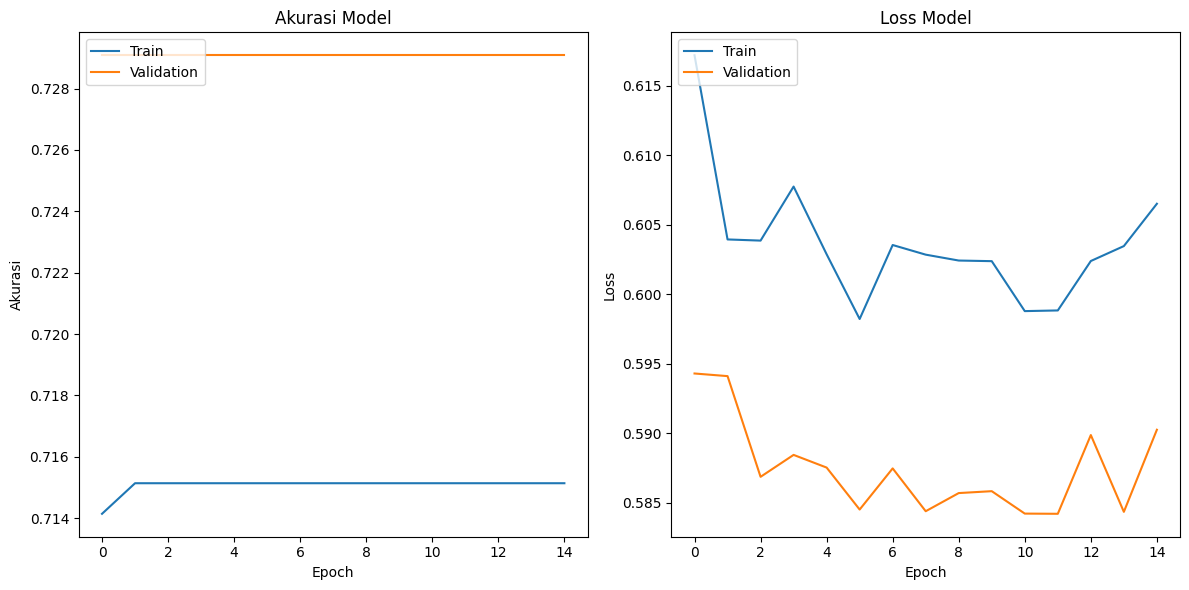

In [29]:
# Evaluasi model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Loss pada data uji: {loss:.4f}")
print(f"Akurasi pada data uji: {accuracy:.4f}")
# Visualisasi hasil
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Akurasi Model')
plt.ylabel('Akurasi')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [31]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
model = load_model('best_model.keras')

np.random.seed(42)
indeks_sampel = np.random.choice(X_test.shape[0], 10, replace=False)
X_sampel = X_test[indeks_sampel]
y_sampel = y_test.iloc[indeks_sampel]

# prediksi pada sampel
predictions_sampel = model.predict(X_sampel)
predictions_sampel_label = (predictions_sampel > 0.5).astype(int).flatten()

print("--- Validasi Manual Model ---\n")
print(f"{'No.':<4} | {'Teks Asli':<50} | {'Label Asli':<12} | {'Prediksi Model'}")
print("-" * 95)
for i, (teks_index_di_test, true_label) in enumerate(zip(indeks_sampel, y_sampel)):
    indeks_asli = y_test.index[teks_index_di_test]
    teks_asli = df.loc[indeks_asli, 'full_text']
    prediksi_model = "Buzzer" if predictions_sampel_label[i] == 1 else "Bukan Buzzer"
    label_asli = "Buzzer" if true_label == 1 else "Bukan Buzzer"
    print(f"{i+1:<4} | {teks_asli[:45]:<50}... | {label_asli:<12} | {prediksi_model}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
--- Validasi Manual Model ---

No.  | Teks Asli                                          | Label Asli   | Prediksi Model
-----------------------------------------------------------------------------------------------
1    | Danantara mengelola investasi secara transpar     ... | Buzzer       | Buzzer
2    | @tempodotco Akibat Koruptor dilindungi. Jokow     ... | Buzzer       | Buzzer
3    | Buka Opsi Rekrut Tokoh Luar Negeri Prabowo In     ... | Bukan Buzzer | Buzzer
4    | Menteri BUMN Erick Thohir tegaskan Danantara      ... | Buzzer       | Buzzer
5    | Presiden Prabowo resmi meluncurkan Danantara      ... | Buzzer       | Buzzer
6    | Presiden RI Prabowo Subianto mencium tangan M     ... | Buzzer       | Buzzer
7    | Danantara diresmikan BUMN tetap setia menjala     ... | Buzzer       | Buzzer
8    | BPI Danantara merupakan salah satu SWF yang h     ... | Buzzer       | Buzzer
9    | Bertemu Prabowo Kadin Harap Berkolaborasi den     ... | B

In [32]:
import numpy as np
import pandas as pd

# Pastikan Anda memiliki df, X_test, dan y_test dari langkah sebelumnya
# Gunakan seed yang sama untuk mendapatkan sampel acak yang identik
np.random.seed(42)

# Ambil 10 indeks acak dari data uji
indeks_sampel_test = np.random.choice(X_test.shape[0], 10, replace=False)

# Dapatkan indeks asli dari DataFrame utama
indeks_asli_df = y_test.index[indeks_sampel_test]

# Ambil sampel dari DataFrame utama menggunakan indeks asli
df_sampel = df.loc[indeks_asli_df].copy()

# Tampilkan kolom-kolom yang relevan
kolom_tampil = ['full_text', 'label_time', 'label_similarity_wmd', 'label_final']
print("--- Verifikasi Aturan Pelabelan pada Sampel ---")
print(df_sampel[kolom_tampil].to_string())

--- Verifikasi Aturan Pelabelan pada Sampel ---
                                                                                                                                                                                                                                                                                                    full_text  label_time  label_similarity_wmd  label_final
1212                                                                                                                                                                                                                       Danantara mengelola investasi secara transparan #Danantara https://t.co/vun99Imjpf           1                     1            1
1121                                                         @tempodotco Akibat Koruptor dilindungi. Jokowi dan keluarga jadi pengurus Danantara. pemerintah kehilangan kepercayaan. jangankan investor Asing. nasabah lokalpun hengkang. Presiden @prabowo. b

In [34]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model

# Pastikan Anda telah menjalankan sel-sel sebelumnya
# Model terbaik yang sudah dilatih dan disimpan akan dimuat
model = load_model('best_model.keras')

# Pastikan Anda memiliki X_test dan y_test dari langkah sebelumnya
# Gunakan seed yang sama untuk mendapatkan sampel acak yang identik
np.random.seed(42)

# Ambil 10 indeks acak dari data uji
indeks_sampel = np.random.choice(X_test.shape[0], 10, replace=False)

# Ambil sampel dari data uji dan label yang sesuai
X_sampel = X_test[indeks_sampel]
y_sampel = y_test.iloc[indeks_sampel]

# Lakukan prediksi pada sampel
predictions_sampel = model.predict(X_sampel)
predictions_sampel_label = (predictions_sampel > 0.5).astype(int).flatten()

# Ambil teks asli dari DataFrame utama menggunakan indeks asli dari sampel uji
# Pastikan Anda memiliki DataFrame 'df' dari langkah pemuatan data
indeks_asli_df = y_test.index[indeks_sampel]
teks_asli_sampel = df.loc[indeks_asli_df, 'full_text'].tolist()

# Buat DataFrame untuk menampilkan hasil
hasil_prediksi_df = pd.DataFrame({
    'Teks Asli': teks_asli_sampel,
    'Label Asli (Buzzer=1)': y_sampel.tolist(),
    'Prediksi Model (Buzzer=1)': predictions_sampel_label,
    'Probabilitas Buzzer': predictions_sampel.flatten() # Tambahkan kolom probabilitas
})

# Ubah label angka menjadi string 'Buzzer'/'Bukan Buzzer' untuk tampilan yang lebih mudah dibaca
hasil_prediksi_df['Label Asli'] = hasil_prediksi_df['Label Asli (Buzzer=1)'].apply(lambda x: 'Buzzer' if x == 1 else 'Bukan Buzzer')
hasil_prediksi_df['Prediksi Model'] = hasil_prediksi_df['Prediksi Model (Buzzer=1)'].apply(lambda x: 'Buzzer' if x == 1 else 'Bukan Buzzer')

# Tampilkan kolom-kolom yang diinginkan
kolom_tampil = ['Teks Asli', 'Label Asli', 'Prediksi Model', 'Probabilitas Buzzer']

print("--- Validasi Manual Model ---")
# Gunakan display() untuk tampilan tabel yang lebih baik di Colab
display(hasil_prediksi_df[kolom_tampil])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
--- Validasi Manual Model ---


,Teks Asli,Label Asli,Prediksi Model,Probabilitas Buzzer
0,Danantara mengelola investasi secara transpara...,Buzzer,Buzzer,0.72457
1,@tempodotco Akibat Koruptor dilindungi. Jokowi...,Buzzer,Buzzer,0.72457
2,Buka Opsi Rekrut Tokoh Luar Negeri Prabowo Ing...,Bukan Buzzer,Buzzer,0.72457
3,Menteri BUMN Erick Thohir tegaskan Danantara b...,Buzzer,Buzzer,0.72457
4,Presiden Prabowo resmi meluncurkan Danantara l...,Buzzer,Buzzer,0.72457
5,Presiden RI Prabowo Subianto mencium tangan Ma...,Buzzer,Buzzer,0.72457
6,Danantara diresmikan BUMN tetap setia menjalan...,Buzzer,Buzzer,0.72457
7,BPI Danantara merupakan salah satu SWF yang he...,Buzzer,Buzzer,0.72457
8,Bertemu Prabowo Kadin Harap Berkolaborasi deng...,Buzzer,Buzzer,0.72457
9,Danantara mengonsolidasikan dan mengelola aset...,Buzzer,Buzzer,0.72457


### Uji Model dengan Sampel Teks Baru

In [36]:
# 1. Tentukan Sampel Teks (diubah ke topik demo)
sample_texts = [
    "Mahasiswa gelar aksi demo besar-besaran di depan gedung DPR menuntut stabilitas harga kebutuhan pokok. #AksiRakyat #HidupMahasiswa",
    "Tolak UU baru! Ribuan buruh turun ke jalan sampaikan aspirasi. Aparat berjaga ketat. #BuruhMelawan #Reformasi",
    "Demo hari ini berlangsung damai, massa sampaikan orasi bergantian. Semoga tuntutan didengar pemerintah. #SuaraRakyat #Demokrasi",
    "Situasi demo memanas, terjadi bentrokan antara massa dan aparat keamanan. Hindari area sekitar! #DemoRicuh #IndonesiaDarurat",
    "Warga kecewa dengan kebijakan pemerintah, siapkan aksi massa lanjutan minggu depan. #MosiTidakPercaya #TurunkanHarga",
    "Artikel: Analisis dampak ekonomi dari gelombang demo yang terjadi di berbagai kota. https://example.com/artikel-demo-ekonomi",
    "Pendapat pribadi: Demo adalah cara warga sampaikan ketidakpuasan, tapi harus tetap damai dan sesuai aturan. #Opini #NegaraHukum",
    "Pemerintah merespons tuntutan demo, berjanji akan meninjau ulang beberapa kebijakan. #PemerintahDengar #DialogNasional",
    "Ada info demo besok di titik A dan B, hindari rute tersebut ya. #InfoDemo #HatiHatiDiJalan",
    "Diskusi publik: Mengapa demo seringkali berujung ricuh di Indonesia? Cari solusinya bersama. #DiskusiPublik #CariSolusi"
]

# Pastikan fungsi cleaning, tokenizer, MAX_LEN, dan model sudah tersedia dari sel-sel sebelumnya

# 2. Bersihkan Sampel Teks
cleaned_sample_texts = [cleaning(text) for text in sample_texts]
print("Sampel teks setelah dibersihkan:")
for i, text in enumerate(cleaned_sample_texts):
    print(f"{i+1}: {text}")
print("-" * 30)

# 3. Tokenisasi dan Padding Sampel Teks
# Gunakan tokenizer dan MAX_LEN yang sudah dilatih dari data asli
sample_sequences = tokenizer.texts_to_sequences(cleaned_sample_texts)
padded_sample_sequences = pad_sequences(sample_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
print("Sampel teks setelah tokenisasi dan padding (contoh 1):")
print(padded_sample_sequences[0])
print("-" * 30)


# 4. Muat Model yang Sudah Dilatih (jika belum dimuat)
# Pastikan model sudah dimuat di sel sebelumnya atau muat di sini
try:
    model
except NameError:
    print("Memuat model dari 'best_model.keras'...")
    from tensorflow.keras.models import load_model
    model = load_model('best_model.keras')
    print("Model berhasil dimuat.")
print("-" * 30)

# 5. Prediksi pada Sampel Teks
print("Melakukan prediksi pada sampel teks...")
predictions_sample = model.predict(padded_sample_sequences)
predictions_sample_label = (predictions_sample > 0.5).astype(int).flatten()

# Ubah label angka menjadi string 'Buzzer'/'Bukan Buzzer'
predicted_labels_str = ['Buzzer' if label == 1 else 'Bukan Buzzer' for label in predictions_sample_label]

# 6. Tampilkan Hasil dalam Tabel
hasil_prediksi_sample_df = pd.DataFrame({
    'Teks Asli': sample_texts,
    'Teks Bersih': cleaned_sample_texts,
    'Prediksi Model': predicted_labels_str,
    'Probabilitas Buzzer': predictions_sample.flatten()
})

print("\nHasil Prediksi pada Sampel Teks:")
display(hasil_prediksi_sample_df)

Sampel teks setelah dibersihkan:
1: mahasiswa gelar aksi demo besarbesaran gedung dpr menuntut stabilitas harga kebutuhan pokok
2: tolak uu ribuan buruh turun jalan aspirasi aparat berjaga ketat
3: demo damai massa orasi bergantian semoga tuntutan didengar pemerintah
4: situasi demo memanas bentrokan massa aparat keamanan hindari area
5: warga kecewa kebijakan pemerintah siapkan aksi massa lanjutan minggu
6: artikel analisis dampak ekonomi gelombang demo kota
7: pendapat pribadi demo warga ketidakpuasan damai sesuai aturan
8: pemerintah merespons tuntutan demo berjanji meninjau ulang kebijakan
9: info demo besok titik a b hindari rute ya
10: diskusi publik demo seringkali berujung ricuh indonesia cari solusinya
------------------------------
Sampel teks setelah tokenisasi dan padding (contoh 1):
[1816    1 1704  837 1168    1   62 1976 1528  444  474 1495    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0 

,Teks Asli,Teks Bersih,Prediksi Model,Probabilitas Buzzer
0,Mahasiswa gelar aksi demo besar-besaran di dep...,mahasiswa gelar aksi demo besarbesaran gedung ...,Buzzer,0.72457
1,Tolak UU baru! Ribuan buruh turun ke jalan sam...,tolak uu ribuan buruh turun jalan aspirasi apa...,Buzzer,0.72457
2,"Demo hari ini berlangsung damai, massa sampaik...",demo damai massa orasi bergantian semoga tuntu...,Buzzer,0.72457
3,"Situasi demo memanas, terjadi bentrokan antara...",situasi demo memanas bentrokan massa aparat ke...,Buzzer,0.72457
4,"Warga kecewa dengan kebijakan pemerintah, siap...",warga kecewa kebijakan pemerintah siapkan aksi...,Buzzer,0.72457
5,Artikel: Analisis dampak ekonomi dari gelomban...,artikel analisis dampak ekonomi gelombang demo...,Buzzer,0.72457
6,Pendapat pribadi: Demo adalah cara warga sampa...,pendapat pribadi demo warga ketidakpuasan dama...,Buzzer,0.72457
7,"Pemerintah merespons tuntutan demo, berjanji a...",pemerintah merespons tuntutan demo berjanji me...,Buzzer,0.72457
8,"Ada info demo besok di titik A dan B, hindari ...",info demo besok titik a b hindari rute ya,Buzzer,0.72457
9,Diskusi publik: Mengapa demo seringkali beruju...,diskusi publik demo seringkali berujung ricuh ...,Buzzer,0.72457
